In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn 
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from torch.utils.data import DataLoader

In [3]:
df1 = pd.read_csv("./data/FPT.csv")
df1['Date/Time'] = pd.to_datetime(df1['Date/Time'])
df1.drop(columns=['Open Interest'], inplace=True)
df1

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500
...,...,...,...,...,...,...,...
97401,FPT,2020-12-22 14:24:00,58.20,58.20,58.20,58.20,27470
97402,FPT,2020-12-22 14:25:00,58.20,58.20,58.20,58.20,14820
97403,FPT,2020-12-22 14:26:00,58.20,58.20,58.20,58.20,500
97404,FPT,2020-12-22 14:29:00,58.10,58.10,58.10,58.10,2500


In [4]:
df1 = df1[['Date/Time', 'Close']]
df1 

,Date/Time,Close
0,2018-12-25 09:15:00,30.89
1,2018-12-25 09:16:00,30.81
2,2018-12-25 09:17:00,30.74
3,2018-12-25 09:18:00,30.74
4,2018-12-25 09:19:00,30.74
...,...,...
97401,2020-12-22 14:24:00,58.20
97402,2020-12-22 14:25:00,58.20
97403,2020-12-22 14:26:00,58.20
97404,2020-12-22 14:29:00,58.10


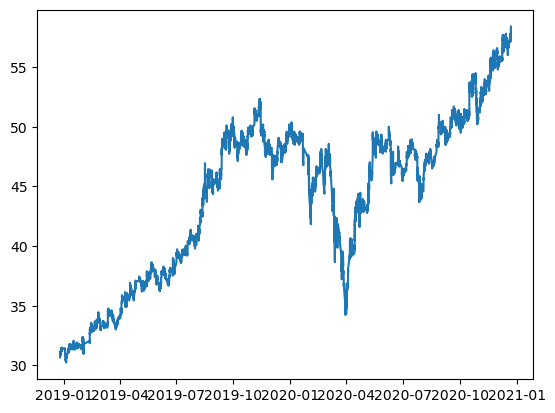

In [5]:
plt.plot(df1['Date/Time'], df1['Close'])

In [6]:
# See previous
from copy import deepcopy as dc 
def prepare_dataframe_from_lstm(df1, n_steps):
    df1 = dc(df1)
    df1.set_index('Date/Time', inplace=True)
    
    for i in range (1, n_steps + 1):
        df1[f'Close(t-{i})'] = df1['Close'].shift(i)
    df1.dropna(inplace=True)
    return df1


lookback = 10
shifted_df = prepare_dataframe_from_lstm(df1, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date/Time,,,,,,,,,,,
2018-12-26 09:18:00,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74,30.81,30.89
2018-12-26 09:19:00,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74,30.81
2018-12-26 09:20:00,31.11,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74,30.74
2018-12-26 09:22:00,31.11,31.11,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74,30.74
2018-12-26 09:23:00,31.19,31.11,31.11,31.11,31.15,31.19,31.19,31.11,30.66,30.74,30.74
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22 14:24:00,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10,58.10,58.10,58.20
2020-12-22 14:25:00,58.20,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10,58.10,58.10
2020-12-22 14:26:00,58.20,58.20,58.20,58.20,58.10,58.10,58.10,58.10,58.10,58.10,58.10


In [7]:
#Scaler data
shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np.shape

(97396, 11)

In [8]:
#Split data X, Y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X = dc(np.flip(X, axis=1))
X


array([[-0.95452931, -0.96021314, -0.9651865 , ..., -0.93889876,
        -0.93321492, -0.93321492],
       [-0.96021314, -0.9651865 , -0.9651865 , ..., -0.93321492,
        -0.93321492, -0.93605684],
       [-0.9651865 , -0.9651865 , -0.9651865 , ..., -0.93321492,
        -0.93605684, -0.93889876],
       ...,
       [ 0.97868561,  0.97868561,  0.97868561, ...,  0.98579041,
         0.98579041,  0.98579041],
       [ 0.97868561,  0.97868561,  0.97868561, ...,  0.98579041,
         0.98579041,  0.98579041],
       [ 0.97868561,  0.97868561,  0.97868561, ...,  0.98579041,
         0.98579041,  0.97868561]])

In [15]:
#Split data for training and validation 
split_index = int(len(X) * 0.80)
split_index
X_train = X[:split_index]
X_train = X_train.reshape((-1, lookback, 1))
X_test = X[split_index:]
X_test = X_test.reshape((-1, lookback, 1))

y_train = y[:split_index]
y_train = y_train.reshape((-1, 1))
y_test = y[split_index:]
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((77916, 10, 1), (19480, 10, 1), (77916, 1), (19480, 1))

In [19]:
# Convert to tensor 
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_12348\3189477695.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\Admin\AppData\Local\Temp\ipykernel_12348\3189477695.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\Admin\AppData\Local\Temp\ipykernel_12348\3189477695.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\Admin\AppData\Local\Temp\ipykernel_12348\3189477695.py:5: UserWarning: To copy

(torch.Size([77916, 10, 1]),
 torch.Size([19480, 10, 1]),
 torch.Size([77916, 1]),
 torch.Size([19480, 1]))

In [20]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
validation_dataset = TimeSeriesDataset(X_test, y_test)


In [21]:
device ='cpu'

In [22]:
#Config
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [23]:
device ='cpu'
device

'cpu'

In [24]:
#Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.lstm = nn.LSTM(input_size, hidden_size, layers, batch_first=True)   
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
# Setup train
model = LSTM(1, 4, 1)
learning_rate = 0.01
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# Train 
def train(model, criterion, train_loader, validation_loader, optimizer, epochs):
    i = 0
    loss_accuracy = {'training_loss':[], 'validation_accuracy':[]}  
    
    for epoch in range(epochs):
        for i,(x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_accuracy['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            yhat = model(x)
            _, label = torch.max(yhat, 1)
            correct += (label==y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        loss_accuracy['validation_accuracy'].append(accuracy)
        
    return loss_accuracy

In [27]:
MSE = train(model, criterion, train_loader, validation_loader, optimizer, num_epochs)

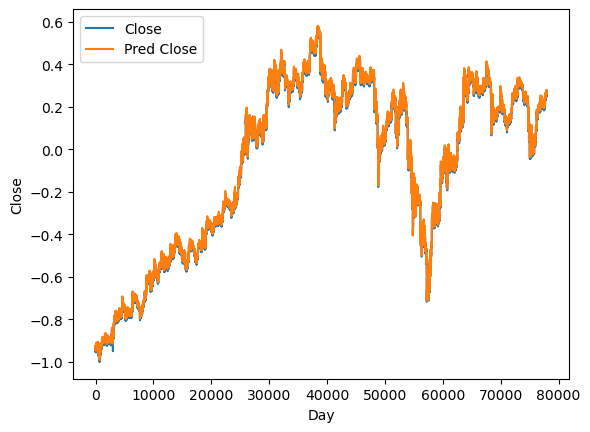

In [28]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Close')
plt.plot(predicted, label='Pred Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [29]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([31.32162752, 31.31223564, 31.27005984, ..., 48.13951667,
       48.14780996, 48.2338172 ])

In [30]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([31.1499998 , 31.1100002 , 31.1100002 , ..., 48.00000004,
       48.09999987, 48.09999987])

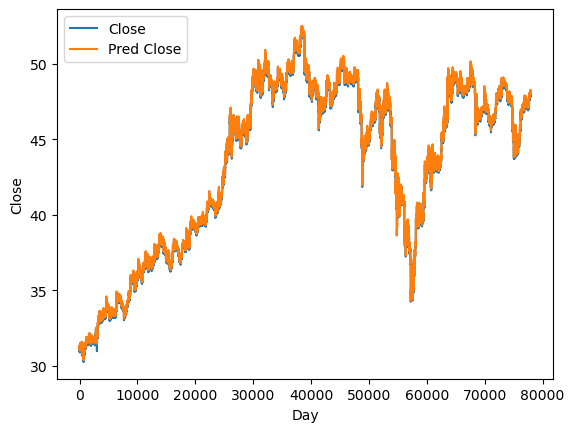

In [31]:
plt.plot(new_y_train, label='Close')
plt.plot(train_predictions, label='Pred Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [32]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([48.25067309, 48.25156529, 48.25010345, ..., 58.49047918,
       58.50194575, 58.48380125])

In [33]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([48.09999987, 48.09999987, 48.15      , ..., 58.20000032,
       58.10000007, 58.10000007])

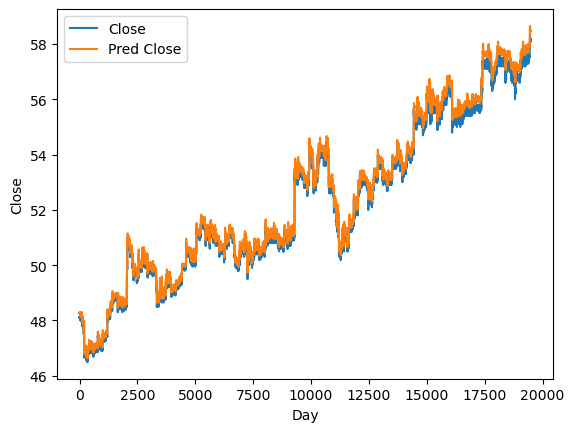

In [34]:
plt.plot(new_y_test, label='Close')
plt.plot(test_predictions, label='Pred Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()